* [1. Загрузка данных](#load)
* [2. Приведение типов данных](#types)
* [3. EDA](#eda)
    * [Обзор количественных переменных](#numeric)
    * [Обзор номинативных переменных](#cats)
* [4. Обработка выбросов](#outlier)
* [5. Обработка пропусков](#nan)
* [6. Построение новых признаков](#feature)
    * [Категориальные переменные](#category)
    * [Вещественные переменные](#numeric_feature)
* [7. Отбор признаков](#feature_selection)
* [8. Разбиение на train и test](#split)
* [9. Построение модели](#modeling)
* [10. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

# Модели
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
# Разделение датасета, поиск по сетке, кросс-валидация
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
# Статистика
from scipy.stats import mode


# Графика
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Невывод предупреждений
import warnings
warnings.filterwarnings('ignore')

### 1. Загрузка данных <a class='anchor' id='load'>

**Пути к директориям и файлам**

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREPARED_DATASET_PATH = './flat_prepared.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
display(df_train.sample(5), f'TRAIN_DATASET Размер: {df_train.shape}')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3630,5193,0,2.0,80.702341,45.332859,11.0,5,21.0,2013,0.006076,B,B,30,5285,0,645.0,6,6,B,184164.435484
9081,9383,24,2.0,88.407297,NaN,0.0,2,0.0,1977,0.111627,B,B,50,12238,8,1970.0,2,3,B,427473.921933
2054,3212,67,2.0,57.483966,36.532140,9.0,12,16.0,1978,0.007720,B,B,38,4788,2,NaN,0,4,B,244256.756548
4085,4958,102,1.0,43.157502,40.055548,10.0,4,3.0,2017,0.238617,B,B,26,3889,6,705.0,3,6,B,78030.684516
1217,6534,87,3.0,74.638846,45.254541,10.0,10,17.0,1986,0.100456,B,B,43,7227,0,NaN,1,6,A,272178.749159


'TRAIN_DATASET Размер: (10000, 20)'

In [4]:
df_test = pd.read_csv(TEST_DATASET_PATH)
display(df_test.sample(5), f'TEST_DATASET Размер: {df_test.shape}')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3226,3260,0,2.0,43.489378,25.097347,5.0,1,5.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B
3702,908,125,2.0,44.530843,26.229348,5.0,5,5.0,1965,0.040243,B,B,25,3478,11,2729.0,3,1,B
3102,7319,0,1.0,33.495087,17.328233,5.0,4,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B
613,3910,20,2.0,58.760572,31.513073,9.0,13,23.0,2006,0.019509,B,B,37,7687,11,176.0,5,5,B
2570,10486,6,1.0,42.516335,NaN,7.0,13,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B


'TEST_DATASET Размер: (5000, 19)'

**Уменьшение объема памяти, который занимает датасет**

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


### 2. Приведение типов данных<a class='anchor' id='types'>

In [7]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [8]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null object
DistrictId       10000 non-null object
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null int8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null category
Ecology_3        10000 non-null category
Social_1         10000 non-null int8
Social_2         10000 non-null int16
Social_3         10000 non-null int16
Healthcare_1     5202 non-null float32
Helthcare_2      10000 non-null int8
Shops_1          10000 non-null int8
Shops_2          10000 non-null category
Price            10000 non-null float32
dtypes: category(3), float32(8), int16(2), int32(1), int8(4), object(2)
memory usage: 615.6+ KB


### 3. EDA  <a class='anchor' id='eda'>
Цель:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

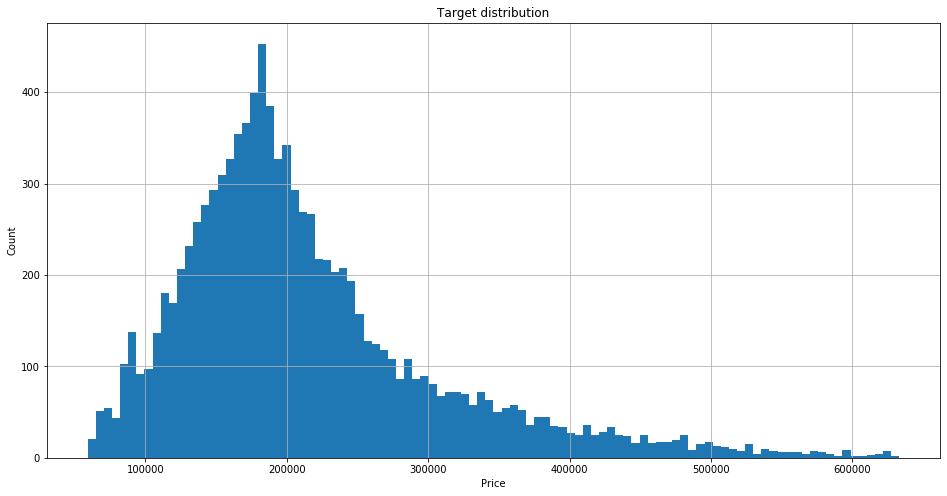

In [10]:
plt.figure(figsize = (16, 8))
df_train['Price'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

In [11]:
# По графику распределения каких-либо видимых отклонений не фиксируется

**Пропуски**

In [12]:
df_train.isna().sum()[df_train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

#### Обзор количественных переменных<a class='anchor' id='numeric'>

In [13]:
df_train.dtypes.value_counts()

float32     8
int8        4
category    3
int16       2
object      2
int32       1
dtype: int64

In [14]:
#df_train.select_dtypes(include=['float32', 'int32', 'int16', 'int8'])

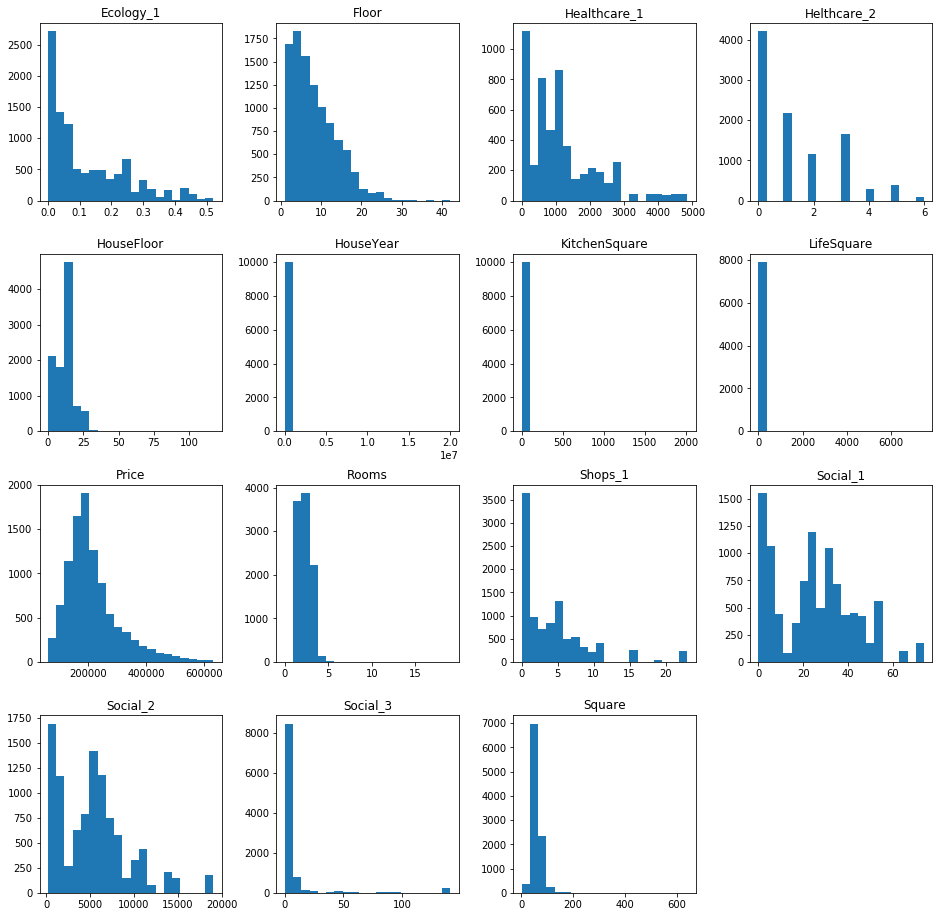

In [15]:
df_train.hist(figsize=(16,16), bins=20, grid=False);

In [16]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Подозрительные данные:

* Rooms: min=0, max=19
* Square: min = 1.137,  среднее больше медианы, выбросы в больших значениях площади 
* LifeSquare: min = 0.37, max = 7480 > max(Square) = 641, среднее больше медианы, выбросы в больших значениях площади, пропуски
* KitchenSquare: min = 0, max = 2014  > max(Square) = 641
* Floor -
* HouseFloor:  max сильно больше max(Floor)
* HouseYear - среднее больше медианы в 2 раза, некорректное максимальное значение
* Ecology_1 - 
* Social_1 - 
* Social_2 - 
* Social_3 - среднее больше медианы > выбросы в больших значениях
* Healthcare_1 - среднее больше медианы > выбросы в больших значениях, пропуски
* Helthcare_2 - 
* Shops_1 -

In [17]:
#df_train.drop('Price', axis = 1).hist(figsize=(15,15), bins=30, grid=False);

#### Обзор Номинативные переменных<a class='anchor' id='cats'>

In [18]:
for i in df_train.drop('Id', axis = 1).select_dtypes(include=['object', 'category']).columns:
    print(f'{i:>30} \n{df_train[i].value_counts()}\n\n')

                    DistrictId 
27     851
1      652
23     565
6      511
9      294
      ... 
207      1
199      1
205      1
196      1
209      1
Name: DistrictId, Length: 205, dtype: int64


                     Ecology_2 
B    9903
A      97
Name: Ecology_2, dtype: int64


                     Ecology_3 
B    9725
A     275
Name: Ecology_3, dtype: int64


                       Shops_2 
B    9175
A     825
Name: Shops_2, dtype: int64




* DistrictId - в тестовой выборке 205 различных районов, от 1 до 851 квартир на 1 район, есть многочисленные районы
* Ecology_2, Ecology_3, Shops_2 - категории из 2х значений (A и B), с преобладающим значением B

### 4. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

In [19]:
"""
- Rooms: min=0, max=19
Square: min = 1.137, среднее больше медианы, выбросы в больших значениях площади
LifeSquare: min = 0.37, max = 7480 > max(Square) = 641, среднее больше медианы, выбросы в больших значениях площади, пропуски
- KitchenSquare: min = 0, max = 2014 > max(Square) = 641
- Floor -
- HouseFloor: max сильно больше max(Floor)
- HouseYear - среднее больше медианы в 2 раза, некорректное максимальное значение
Ecology_1 -
Social_1 -
Social_2 -
Social_3 - среднее больше медианы > выбросы в больших значениях
Healthcare_1 - среднее больше медианы > выбросы в больших значениях, пропуски
Helthcare_2 -
Shops_1 -
"""
pass

**Rooms**

In [20]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
# Значения 0, >5 похожи на ошибочные, выделяются из общей выборки
# Создадим признак Rooms_outlier

df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1

# Проверим предположение, сопоставив кол-во комнат с площадью
df_train[df_train['Rooms_outlier'] == 1].\
sort_values(by = ['Rooms', 'Square'])[['Rooms','Square', 'LifeSquare', 'KitchenSquare', 'Price']]

,Rooms,Square,LifeSquare,KitchenSquare,Price
9869,0.0,2.377248,0.873147,0.0,126596.945312
2194,0.0,38.697117,19.345131,9.0,158998.109375
3780,0.0,41.790882,NaN,0.0,98129.976562
5894,0.0,49.483501,NaN,0.0,217009.343750
7929,0.0,81.491447,NaN,0.0,212864.796875
6401,0.0,87.762619,85.125473,0.0,219281.921875
9767,0.0,138.427689,136.215500,0.0,268394.750000
7644,0.0,212.932358,211.231125,0.0,302211.250000
8794,6.0,59.414333,38.702244,6.0,229661.968750
2004,10.0,59.056976,36.223072,10.0,317265.312500


данные не похожи на фактические, предположительно ошибочные значения заменим на расчетное: 
площадь/(Медиана площади 1 комнаты)

In [22]:
# Медиана площади 1 комнаты

square_per_room = (df_train['Square']/df_train['Rooms']).median()

# Заменим предположительно ошибочные значения кол-ва комнат на расчетное в зависимости от общей площади  

condition = (df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6)
df_train.loc[condition, 'Rooms'] = round(df_train.loc[condition, 'Square']/square_per_room)

# Нулевые значения меняем на 1
df_train.loc[(df_train['Rooms'] == 0), 'Rooms'] = 1

df_train[df_train['Rooms_outlier'] == 1].sort_values(by = ['Rooms', 'Square'])\
[['Rooms','Square', 'LifeSquare', 'KitchenSquare', 'Price']]

,Rooms,Square,LifeSquare,KitchenSquare,Price
9869,1.0,2.377248,0.873147,0.0,126596.945312
2194,1.0,38.697117,19.345131,9.0,158998.109375
3780,1.0,41.790882,NaN,0.0,98129.976562
6088,1.0,42.006046,21.779287,7.0,78364.617188
5894,2.0,49.483501,NaN,0.0,217009.343750
2004,2.0,59.056976,36.223072,10.0,317265.312500
8794,2.0,59.414333,38.702244,6.0,229661.968750
2728,2.0,60.871265,38.420681,10.0,172329.265625
7929,3.0,81.491447,NaN,0.0,212864.796875
6401,3.0,87.762619,85.125473,0.0,219281.921875


In [23]:
df_train['Rooms'].value_counts()

2.0    3884
1.0    3709
3.0    2237
4.0     151
5.0      18
7.0       1
Name: Rooms, dtype: int64

**Square, LifeSquare**

In [24]:
#plt.hist(df_train['Square'], density = True, bins = 20, alpha = 0.5, label='Class 0', color='grey')
#plt.hist(df_train['LifeSquare'], density = True, bins = 20, alpha = 0.5, label='Class 1', color='red')
#plt.show

In [25]:
#df_train.sort_values(by = 'Square', ascending = False)

# посчитаем квантили 99.9%, 0.1%, Рассмотрим крайние значения Square и LifeSquare выбивающиеся за квантили

for i in 'Square', 'LifeSquare':
    display(i, f'Квантили 99.9%, 0.1%: {df_train[i].quantile(.999), df_train[i].quantile(.001)}',
            df_train[(df_train[i] < df_train[i].quantile(.001)) | (df_train[i] > df_train[i].quantile(.999))].sort_values(by = i, ascending = False))

'Square'

'Квантили 99.9%, 0.1%: (183.38480256652883, 5.128915897369385)'

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.687500,0
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,...,B,25,5648,1,30.0,2,4,B,187717.250000,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
7644,7917,27,7.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
1776,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0
9307,4249,23,5.0,198.930176,123.139862,10.0,1,2.0,2011,0.014073,...,B,2,475,0,NaN,0,0,B,345665.218750,0
1606,3718,56,3.0,190.857681,107.376167,19.0,7,3.0,2007,0.000000,...,B,23,5067,4,NaN,2,6,B,338644.062500,0
8011,3233,129,4.0,186.692596,87.487083,32.0,3,3.0,2011,0.020741,...,B,24,5613,5,1340.0,2,5,B,423443.468750,0
2790,15947,129,4.0,185.906403,84.830078,31.0,5,3.0,2015,0.020741,...,B,24,5613,5,1340.0,2,5,B,340273.250000,0


'LifeSquare'

'Квантили 99.9%, 0.1%: (177.89117, 1.1409528)'

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
8000,16550,27,3.0,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,...,B,2,469,0,NaN,0,0,B,217357.500000,0
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.687500,0
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,394253.312500,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
357,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,...,B,6,1437,3,NaN,0,2,B,141780.234375,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
7644,7917,27,7.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
1776,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0
7626,12245,23,2.0,67.032997,1.139667,1.0,3,17.0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,185006.421875,0
2687,6631,85,1.0,48.990532,1.104689,1.0,5,17.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,124761.835938,0


- ранее фиксировали среднее больше медианы, выбросы в больших значениях площади 
- значения площади Square и LifeSquare могут отличаться на порядок
- часто LifeSquare > Square

In [26]:
# В случае LifeSquare > Square поменяем их местами 

df_train['Square_outlier'] = 0
condition = (df_train['Square'] < df_train['LifeSquare'])
df_train.loc[condition, 'Square_outlier'] = 1

df_train['Square'], df_train['LifeSquare'] = \
np.where(condition,
         (df_train['LifeSquare'], df_train['Square']),
         (df_train['Square'], df_train['LifeSquare']))

In [27]:
# Для случаев где Жилая площадь в 3 и более раза меньше общей площади меняем на значение 
# площадь за вычетом медианного значение площади кухни

KitchenSquare_median = df_train['KitchenSquare'].median()

df_train['LifeSquare_outlier'] = 0
condition = (df_train['Square']/df_train['LifeSquare'] > 3) & (df_train['Square'] > KitchenSquare_median)
df_train.loc[condition, 'LifeSquare_outlier'] = 1
df_train.loc[condition, 'LifeSquare'] = df_train.loc[condition, 'Square'] - KitchenSquare_median

In [28]:
print('KitchenSquare_median = ', KitchenSquare_median)
df_train[(df_train['Square'] < 10) | (df_train['Square'] > 200)].sort_values(by = 'Square', ascending = False)

KitchenSquare_median =  6.0


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
8000,16550,27,3.0,7480.592285,7474.592285,1.0,9,17.0,2016,0.017647,...,469,0,NaN,0,0,B,217357.500000,0,1,1
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,6398,141,1046.0,3,23,B,133529.687500,0,0,0
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,...,5648,1,30.0,2,4,B,187717.250000,0,0,0
5183,15886,85,3.0,461.463623,455.463623,10.0,12,16.0,1998,0.037178,...,11217,1,2300.0,1,7,B,394253.312500,0,1,1
7010,2307,102,1.0,410.639740,409.425171,10.0,4,4.0,2016,0.238617,...,3889,6,705.0,3,6,B,90470.429688,0,1,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,7010,5,4508.0,3,7,B,455264.875000,0,0,0
357,14990,23,2.0,263.542023,257.542023,5.0,6,5.0,1972,0.075779,...,1437,3,NaN,0,2,B,141780.234375,0,1,1
7644,7917,27,7.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,NaN,0,1,B,302211.250000,1,0,0
1776,16568,27,4.0,201.627365,200.334534,25.0,1,2.0,2013,0.041116,...,14892,4,NaN,1,4,B,528560.500000,0,1,0
328,4504,27,3.0,5.610772,4.390331,1.0,8,19.0,2016,0.211401,...,1892,0,NaN,0,1,B,161379.062500,0,1,0


In [29]:
df_train['Square'].quantile(.999), df_train['Square'].quantile(.001)

(190.86575376892253, 16.117026809692383)

**KitchenSquare**

In [30]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [31]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [32]:
# condition - нет данных или площать более кванитля 97.5

condition = (df_train['KitchenSquare'].isna()) \
             | (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975))

# доп признак KitchenSquare_outlier при нет данных или площать более кванитля 97.5 

df_train['KitchenSquare_outlier'] = 0
df_train.loc[condition | (df_train['KitchenSquare'] < 3), 'KitchenSquare_outlier'] = 1

# нет данных или площать более кванитля 97.5 замена на медиану
df_train.loc[condition, 'KitchenSquare'] = KitchenSquare_median

# площать кухни менее 3х метров меняем на 3
df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3


# кухни, размер которых больше разницы между общей и жилой площадью - заменяем на разницу между общей и жилой площадью
condition = (df_train['KitchenSquare'] > df_train['Square'] - df_train['LifeSquare']) &\
(df_train['Square'] > df_train['LifeSquare']) &\
(~df_train['LifeSquare'].isna())

df_train.loc[condition, 'KitchenSquare_outlier'] = 1
df_train.loc[condition, 'KitchenSquare'] = df_train['Square'] - df_train['LifeSquare']


**HouseFloor, Floor**

In [33]:
# Расмотрим граничные значения (по 5 сверху и снизу) этажей и их кол-во

for i in 'HouseFloor', 'Floor':
    display(i, f'Квантиль 99.5%: {df_train[i].quantile(.995)}',
            df_train[i].value_counts().sort_index().head(),
            df_train[i].value_counts().sort_index().tail())

'HouseFloor'

'Квантиль 99.5%: 28.0049999999992'

0.0    269
1.0    497
2.0     48
3.0    127
4.0    134
Name: HouseFloor, dtype: int64

45.0     1
47.0     1
48.0     2
99.0     2
117.0    1
Name: HouseFloor, dtype: int64

'Floor'

'Квантиль 99.5%: 25.0'

1    235
2    588
3    872
4    949
5    876
Name: Floor, dtype: int64

31    1
32    2
33    1
37    1
42    1
Name: Floor, dtype: int64

HouseFloor - есть нулевое значение, которое не встречается у Floor, этажность сильно больше встречающихся этажей (Floor)

In [34]:
# Проверка этаж выше этажности дома
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [35]:
# Признак HouseFloor_outlier, для случаев: этаж = 0, этаж выше этажности, этажность более квантиля 99.5%

df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outlier'] = 1
df_train.loc[df_train['HouseFloor'] > df_train['HouseFloor'].quantile(.995), 'HouseFloor_outlier'] = 1

In [36]:
# этажность = 0, замена на медиану этажности
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

# этажность более квантиля 99.5%, заменяем на значение квантиля 99.5%
df_train.loc[df_train['HouseFloor'] > df_train['HouseFloor'].quantile(.995), 'HouseFloor'] = \
round(df_train['HouseFloor'].quantile(.995))

# этаж выше этажности, меняем их местами
df_train['HouseFloor'], df_train['Floor'] = \
np.where(df_train['HouseFloor'] < df_train['Floor'],
         (df_train['Floor'], df_train['HouseFloor']),
         (df_train['HouseFloor'], df_train['Floor']))



In [37]:
for i in 'HouseFloor', 'Floor':
    display(i, df_train[i].value_counts().sort_index().head(),
            df_train[i].value_counts().sort_index().tail())

'HouseFloor'

1.0     13
2.0     44
3.0    118
4.0    186
5.0    871
Name: HouseFloor, dtype: int64

31.0    1
32.0    2
33.0    1
37.0    1
42.0    1
Name: HouseFloor, dtype: int64

'Floor'

1.0     719
2.0     592
3.0     881
4.0     897
5.0    1036
Name: Floor, dtype: int64

23.0    26
24.0    43
25.0    26
26.0     2
28.0     8
Name: Floor, dtype: int64

**HouseYear**

In [38]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [39]:
# Год более текущего заменяется на текущий

df_train.loc[df_train['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

df_train['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7246    2020
2350    2020
8296    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int32

### 5. Обработка пропусков  <a class='anchor' id='nan'>

In [40]:
df_train.isna().sum()[df_train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

**LifeSquare**

In [41]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.000000
1,39.832523,23.169222,8.000000
2,78.342216,47.671970,10.000000
3,40.409908,NaN,3.000000
4,64.285065,38.562515,9.000000
5,62.528465,47.103832,6.000000
6,33.938751,21.772930,9.000000
7,50.391815,32.893257,8.000000
8,46.887894,44.628132,2.259762
9,79.867477,75.085129,3.000000


In [42]:
# признак пропуска
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna() * 1

# condition - пропуск и не пропуск площадь и не пропуск площать кухни
condition = (df_train['LifeSquare'].isna()) & (~df_train['Square'].isna()) & (~df_train['KitchenSquare'].isna())

# при condition присваиваем значение площать за вычетом площади кухни - 3кв.м
df_train.loc[condition, 'LifeSquare'] = df_train.loc[condition, 'Square'] - df_train.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [43]:
# Рассмотрим top5 густонаселенных районов

df_train.DistrictId.value_counts().head(10)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
53    174
21    165
Name: DistrictId, dtype: int64

In [44]:
# Смотрим кол-во уникальных значение Healthcare_1 в каждом из top10 густонаселенных районов

for i in df_train.DistrictId.value_counts().head(10).index:
    display(f'Район {i}', df_train[df_train.DistrictId == i]['Healthcare_1'].value_counts().unique())

'Район 27'

array([], dtype=int64)

'Район 1'

array([41, 16], dtype=int64)

'Район 23'

array([1], dtype=int64)

'Район 6'

array([511], dtype=int64)

'Район 9'

array([202], dtype=int64)

'Район 62'

array([9], dtype=int64)

'Район 30'

array([228], dtype=int64)

'Район 58'

array([106,  27,  20,   6,   1], dtype=int64)

'Район 53'

array([146,  25,   3], dtype=int64)

'Район 21'

array([97,  3,  2], dtype=int64)

Возможное кол-во вариантов Healthcare_1 = от 1 до 5 на районы от 165 до 851 квартир, 
т.о. пропуски заменим на среднее значение по району, если у района нет значения, заменим на среднее по всей выборке

In [45]:
# Сформируем словарь Район - ср.зн Healthcare_1, если у района нет значения, заменим на среднее по всей выборке

distr_healthcare = df_train.groupby(by = 'DistrictId').mean()['Healthcare_1'].fillna(df_train.Healthcare_1.mean()).to_dict()
distr_healthcare['0'], distr_healthcare['1'], distr_healthcare['27']

(2073.583251953125, 228.7719268798828, 1142.9044189453125)

In [46]:
# Заменим пропуски ср.значениями Healthcare_1 по принадлежности к району

df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1'] =\
df_train.loc[df_train['Healthcare_1'].isna(), 'DistrictId'].map(distr_healthcare)

#### DataPreprocessing

In [47]:
class DataPreprocessing:
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.square_per_room = None
        self.kitchen_square_quantile_975 = None
        self.house_floor_quantile995 = None
        self.distr_healthcare = None
        
        #self.kitchen_square_quantile = None
        #self.house_floor_quantile = None

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Медиана площади 1 комнаты
        self.square_per_room = (X['Square']/X['Rooms']).median()
        self.kitchen_square_quantile_975 = X['KitchenSquare'].quantile(.975)
        self.house_floor_quantile995 = X['HouseFloor'].quantile(.995)
        # словарь Район - ср.зн Healthcare_1, если у района нет значения, заменим на среднее по всей выборке
        self.distr_healthcare = X.groupby(by = 'DistrictId').mean()['Healthcare_1'].fillna(X.Healthcare_1.mean()).to_dict()
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        
        # Значения 0, >5 похожи на ошибочные, выделяются из общей выборки
        # Создадим признак Rooms_outlier
        X['Rooms_outlier'] = 0
        
        # Заменим предположительно ошибочные значения кол-ва комнат на расчетное в зависимости от общей площади  
        condition = (X['Rooms'] == 0) | (X['Rooms'] >= 6)
        X.loc[condition, 'Rooms_outlier'] = 1
        X.loc[condition, 'Rooms'] = round(X.loc[condition, 'Square']/self.square_per_room)

        # Нулевые значения меняем на 1
        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1

        # Square, LifeSquare 

        # В случае LifeSquare > Square поменяем их местами, добавим признак Square_outlier
        X['Square_outlier'] = 0
        
        condition = (X['Square'] < X['LifeSquare'])        
        X.loc[condition, 'Square_outlier'] = 1
        
        X['Square'], X['LifeSquare'] = \
        np.where(condition,
                 (X['LifeSquare'], X['Square']),
                 (X['Square'], X['LifeSquare']))


        # KitchenSquare

        # condition - нет данных или площать более кванитля 97.5
        condition = (X['KitchenSquare'].isna()) \
                     | (X['KitchenSquare'] > self.kitchen_square_quantile_975)

        # доп признак KitchenSquare_outlier при condition и площать менее 3х м 
        X['KitchenSquare_outlier'] = 0
        X.loc[condition | (X['KitchenSquare'] < 3), 'KitchenSquare_outlier'] = 1

        # нет данных или площать более кванитля 97.5 замена на медиану
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        # кухни, размер которых больше разницы между общей и жилой площадью - заменяем на разницу между общей и жилой площадью
        condition = (X['KitchenSquare'] > X['Square'] - X['LifeSquare']) & (X['Square'] > X['LifeSquare']) & (~X['LifeSquare'].isna())
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, 'KitchenSquare'] = X['Square'] - X['LifeSquare']
        
        # площать кухни менее 3х метров меняем на 3
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    
        # Для случаев где Жилая площадь в 2 и более раза меньше общей площади меняем на значение 
        # площадь за вычетом медианного значение площади кухни, добавим признак LifeSquare_outlier
        
        X['LifeSquare_outlier'] = 0
        condition = (X['Square']/X['LifeSquare'] > 2) & (X['Square'] > self.medians['KitchenSquare'])
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - self.medians['KitchenSquare'] - 3
        
        
        # HouseFloor, Floor
        
        # Признак HouseFloor_outlier, для случаев: этаж = 0, этаж выше этажности, этажность более квантиля 99.5%
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > self.house_floor_quantile995, 'HouseFloor_outlier'] = 1

        # этажность = 0, замена на медиану этажности
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()

        # этажность более квантиля 99.5%, заменяем на значение квантиля 99.5%
        X.loc[X['HouseFloor'] > self.house_floor_quantile995, 'HouseFloor'] = \
        round(self.house_floor_quantile995)

        # этаж выше этажности, меняем их местами
        X['HouseFloor'], X['Floor'] = \
        np.where(X['HouseFloor'] < X['Floor'],
                 (X['Floor'], X['HouseFloor']),
                 (X['HouseFloor'], X['Floor']))

        # HouseYear

        # Год более текущего заменяется на текущий
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year
        
        # Пропуски

        # LifeSquare
    
        # признак пропуска
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        # condition - пропуск и не пропуск площадь и не пропуск площать кухни
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())

        # при condition присваиваем значение площать за вычетом площади кухни - 3кв.м
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
       
        # Healthcare_1
        
        # Заменим пропуски ср.значениями Healthcare_1 по принадлежности к району
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] =\
        X.loc[X['Healthcare_1'].isna(), 'DistrictId'].map(self.distr_healthcare)
        
        # Удаляем id
        X.drop(['Id'], axis=1, inplace=True)
        
        # заполнение пропусков если есть в других признаках
        X.fillna(self.medians, inplace=True)
        
        return X



### 6. Построение новых признаков  <a class='anchor' id='feature'>

#### Категориальные переменные  <a class='anchor' id='category'>

**Dummies**

In [48]:
# Перевод категории из 2х значений (A и B) в бинарный признак (0 и 1)

binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].map(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].map(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].map(binary_to_numbers)
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027313,102.027313,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,0,0,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,0,0
3,2352,1,1.0,40.409908,34.409908,3.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,0,1,0,1
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3.0,12.0,1981,0.300323,...,1,9,1,119367.453125,0,0,0,0,0,0
9996,16265,27,2.0,64.307686,37.038422,9.0,13.0,13.0,1977,0.072158,...,0,0,0,199715.156250,0,0,0,0,1,0
9997,2795,178,1.0,29.648056,16.555363,5.0,3.0,5.0,1958,0.460556,...,1,5,1,165953.906250,0,0,0,0,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,3,5,1,171842.406250,0,0,0,0,0,0


Возможные варианты перевода в вещественный:

- feature encoding
- target encoding
- self encoding

**DistrictSize, IsDistrictLarge**
- self encoding

In [49]:
# Добавление нового признака о кол-ве продаваемых квартир в районе (косвенно - населенность района)
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_train = df_train.merge(district_size, on='DistrictId', how='left')
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [50]:
# Ориентировочная граница разбиения 50 на 50 для распределения по большой-нет
(df_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [51]:
# Ввод нового признака - большой или малый район
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**
- target encoding

In [52]:
# средняя цена по принадлежности к району и кол-ву комнат
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146574.015625
4,1,2.0,202706.093750


In [53]:
# Ввод нового признака - средняя цена по принадлежности к району и кол-ву комнат
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

**MedPriceByFloorYear**

- target encoding

In [54]:
# Разбиение по категориям года постройки
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

# Разбиение по категориям этажи
def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [55]:
# Разбиение по категориям года постройки
df_train = year_to_cat(df_train)

# Разбиение по категориям этажи
df_train = floor_to_cat(df_train)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4.0,10.0,2014,0.075424,...,0,0,0,0,1,851,1,213688.718750,5,1
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.828125,2,2
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.281250,3,0
3,2352,1,1.0,40.409908,34.409908,3.0,10.0,22.0,1977,0.007122,...,0,0,1,0,1,652,1,146574.015625,2,3
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,0,0,0,0,89,0,201584.437500,2,4


In [56]:
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,380359.12500
1,0,1,324303.81250
2,0,2,422668.37500
3,0,3,274992.46875
4,1,0,467230.53125


In [57]:
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,851,1,213688.718750,5,1,161744.500000
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.828125,2,2,192213.968750
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.281250,3,0,205210.062500
3,2352,1,1.0,40.409908,34.409908,3.0,10.0,22.0,1977,0.007122,...,0,1,0,1,652,1,146574.015625,2,3,184374.328125
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.437500,2,4,175503.765625


In [58]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        df = X.copy()
        
        # Для перевода категории из 2х значений (A и B) в бинарный признак (0 и 1)
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # кол-во продаваемых квартир в районе (косвенно - населенность района)
        self.district_size = df['DistrictId'].value_counts().reset_index()\
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # медиана населенности района
        self.district_size_median = self.district_size.median()
                
        # Target encoding

        #df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            # средняя цена по принадлежности к району и кол-ву комнат
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()


            # Макс/мин этаж и год постройки
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            
            # признаки принадлежности к категории этажа
            df = self.floor_to_cat(df)
            # признак принадлежности к категории года постройки
            df = self.year_to_cat(df)      
            
            # средняя цена от года и этажа
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()


        
    def transform(self, X):
        
        # Перевод категории из 2х значений (A и B) в бинарный признак (0 и 1)
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        # неизвестный район
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
       
        # Район с неизвстным размером заполняем медианой
        X['DistrictSize'].fillna(self.district_size_median, inplace=True)
        
        # Добавление признака большой ли район
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

        # Добавление признака первый этаж
        X['First_Floor'] = 0
        X.loc[X['Floor'] == 1, 'First_Floor'] = 1
        
        # Добавление признака последний этаж
        X['Last_Floor'] = 0
        X.loc[X['Floor'] == X['HouseFloor'], 'Last_Floor'] = 1
        
        # Добавление признака принадлежности к категории этажа
        X = self.floor_to_cat(X)  # + столбец floor_cat
        
        # Добавление признака принадлежности к категории года постройки
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

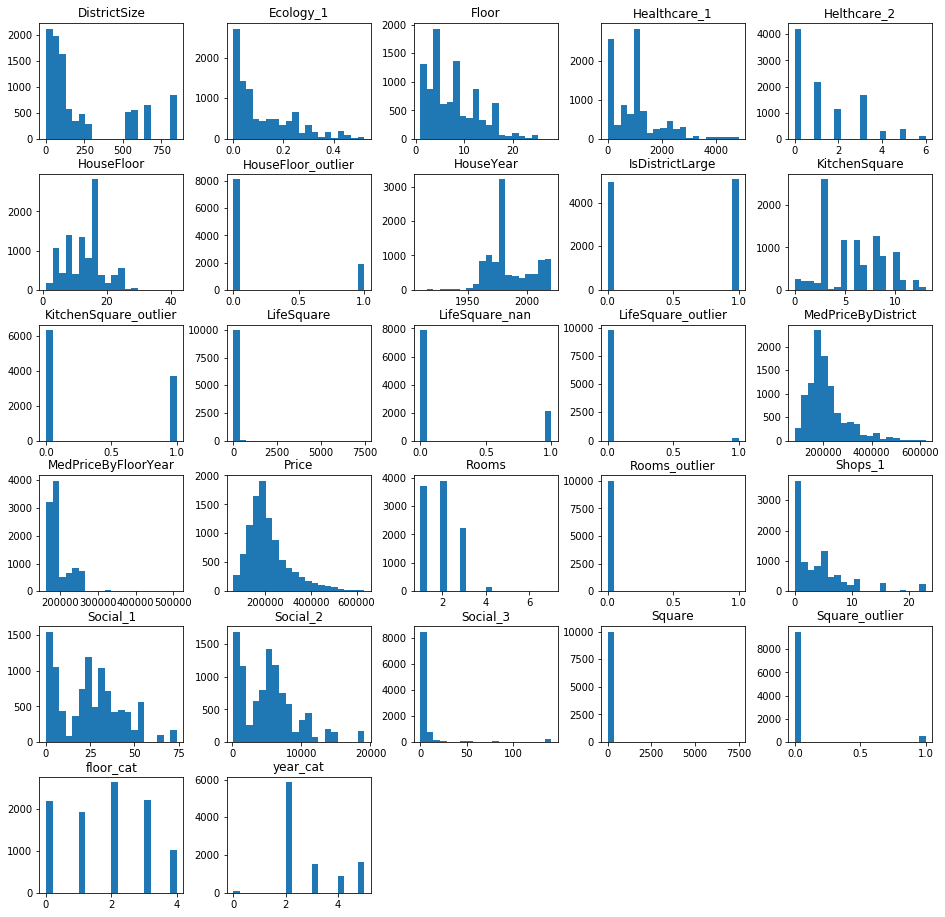

In [59]:
df_train.hist(figsize=(16,16), bins=20, grid=False);

### 7. Отбор признаков  <a class='anchor' id='feature_selection'>

In [60]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [61]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Healthcare_1',
                 'Helthcare_2', 'Shops_1']

new_feature_names = ['Rooms_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 
                     'DistrictSize', 'new_district', 'IsDistrictLarge',  'MedPriceByFloorYear', 'First_Floor', 'Last_Floor']

target_name = 'Price'

### 8. Разбиение на train и test  <a class='anchor' id='split'>

In [62]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [64]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 24), (3300, 24), (5000, 24))

In [65]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 33), (3300, 33), (5000, 33))

In [66]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [67]:
X_train.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Rooms_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'MedPriceByFloorYear',
 'First_Floor',
 'Last_Floor']

### 9. Построение модели  <a class='anchor' id='modeling'>

In [68]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [69]:
"""rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=100, # глубина дерева  
                                 min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
                                 n_estimators=300,  # кол-во деревьев
                                 random_state=10
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)"""

# Полученный результат
# Train R2: 0.873
# Test R2: 0.748
# хуже полученного в модели GradientBoostingRegressor
pass

Train R2:	0.905
Test R2:	0.752


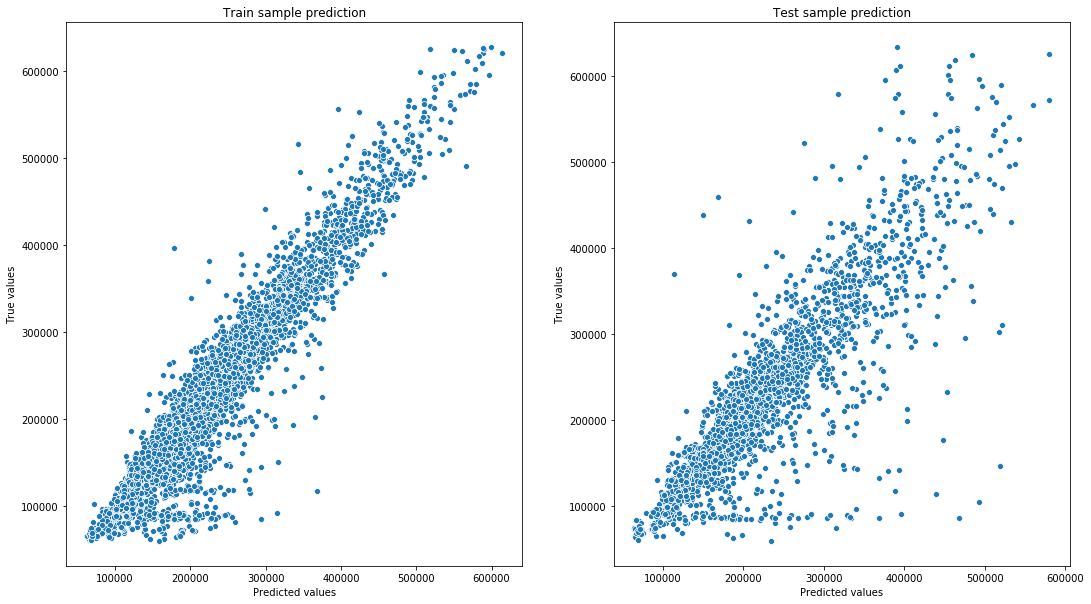

In [70]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

**Кросс-валидация**

In [71]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score, cv_score.mean()

(array([0.73377977, 0.69423598, 0.72977821]), 0.7192646553451536)

In [72]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.435313
20,DistrictSize,0.232040
12,Social_3,0.053242
7,Ecology_1,0.032948
11,Social_2,0.031873
0,Rooms,0.029944
2,LifeSquare,0.028624
13,Healthcare_1,0.026363
6,HouseYear,0.023009
23,MedPriceByFloorYear,0.021039


### 10. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [73]:
df_test.shape

(5000, 26)

In [74]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear,First_Floor,Last_Floor
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,0,0,0,0,76.0,0,0,186265.707329,0,0
1,1.0,42.568133,42.493907,3.0,7.0,17.0,2017,0.072158,1,1,...,0,1,0,0,164.0,0,1,179449.269388,0,0
2,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,1,1,...,0,0,0,1,580.0,0,1,175622.388268,0,1
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,0,0,0,0,372.0,0,1,179525.641685,0,1
4,1.0,53.837056,47.837056,3.0,8.0,17.0,1977,0.309479,1,1,...,0,1,0,1,65.0,0,0,192086.822606,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5.0,6.0,1962,0.069660,1,1,...,0,0,1,0,56.0,0,0,186265.707329,0,0
4996,3.0,94.521465,93.698122,3.0,21.0,27.0,2018,0.060753,1,1,...,0,1,0,0,26.0,0,0,192358.950694,0,0
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,0.038693,1,1,...,0,0,0,0,54.0,0,0,179525.641685,0,0
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,1,1,...,0,0,0,0,40.0,0,0,192086.822606,0,0


In [75]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [76]:
predictions = gb_model.predict(df_test)
predictions

array([159641.5065591 , 119721.1767892 , 142271.79351432, ...,
       144720.91413879, 197541.90918506, 255084.75017334])

In [77]:
submit['Price'] = predictions
submit

,Id,Price
0,4567,159641.506559
1,5925,119721.176789
2,960,142271.793514
3,3848,120349.785981
4,746,215499.246161
...,...,...
4995,10379,176727.126105
4996,16138,408130.367511
4997,3912,144720.914139
4998,5722,197541.909185


In [78]:
submit.to_csv('rf_submit.csv', index=False)